___
# José Luis Padilla Valenzuela

### Caso de aprendizaje supervisado: Problema de clasificación 

___
## Problema de absentismo en el trabajo

El departamento de recursos humanos de una empresa ha analizado los datos de sus empleados y ha descubierto que existe un problema con el absentismo. Han recabado datos y quieren realizar un modelo que clasifique correctamente a los empleados en función de si faltan más de 4 horas al mes o no. Esto les será de utilidad de cara a realizar futuras contrataciones, e incluso hacer un seguimiento a sus empleados actuales.

<img src='invisible.png' width=200></img>

Los datos para la realización de este problema provienen de la University of California Irvine. Más detalles en la siguiente url: https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work

Descárgate el fichero Absenteeism_at_work.csv del campus.

## Carga de librerías:

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Puedes importar las librerías que necesites, algunas de las que puede que necesites
# son las siguientes, siéntete libre para importar las que quieras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
import sklearn as skl
pd.options.display.max_columns = 500

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from IPython.core.display import display, HTML
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Definición de funciones:

In [4]:
# Si no quieres usar estas funciones puedes borrarlas.
# Si quieres definir otras funciones, este es el espacio. 
# También puedes definirlas en un módulo separado.
def relaciones_vs_target(X, Y, return_type='axes'):
    '''
    Función que representa gráficos de dispersión de las variables
    en X en función a la variable Y
    '''
    fig_tot = (len(X.columns))
    fig_por_fila = 4.
    tamanio_fig = 4.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()

def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1', 
                          label_0='Clase 0', density=0):
    '''
    Función que recibe dos distribuciones de probabilidad y las representa
    en el mismo gráfico
    '''
    bins = n_bins
    plt.hist(x_1, bins, density = density, alpha=0.5, label=label_1, color='red')    
    plt.hist(x_0, bins, density = density, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best') 

def hist_pos_neg_feat(x, y, density=0, nbins=11, targets=(0,1)):
    '''
    Representa las variables en x divididas en dos distribuciones
    según su valor de y sea 1 o 0
    '''
    fig_tot = len(x.columns)
    fig_tot_fila = 4.; fig_tamanio = 4.
    num_filas = int( np.ceil(fig_tot/fig_tot_fila) )
    plt.figure( figsize=( fig_tot_fila*fig_tamanio+2, num_filas*fig_tamanio+2 ) )
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i+1);
        plt.title('%s' % feat)
        idx_pos = y == target_pos
        idx_neg= y == target_neg
        represento_doble_hist(x[feat][idx_pos].values, x[feat][idx_neg].values, nbins, 
                   density = density, title=('%s' % feat))

## Carga de datos:

In [5]:
# Pon el fichero Absenteeism_at_work.csv en la misma carpeta que este código.
# Carga los datos, ten en cuenta que el separador es ;
XY = pd.read_csv('C:\\Users\\jlpad\\Desktop\\BBDD\\Absenteeism_at_work.csv', sep=',', index_col=False)

In [6]:
XY.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


¿Cuántas variables de las que denominamos independientes o features tiene el dataset? La target y los identificadores no cuentan como variables predictoras...

In [7]:
# Muestra el número de filas, columnas y variables que hay en el dataset
print(u'- El número de filas en el dataset es: {}'.format(XY.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(XY.shape[1]))
print(u'- Los nombres de las variables independientes son: {}'.format(list(XY.columns)))
XY.head()

- El número de filas en el dataset es: 740
- El número de columnas en el dataset es: 21
- Los nombres de las variables independientes son: ['ID', 'Reason for absence', 'Month of absence', 'Day of the week', 'Seasons', 'Transportation expense', 'Distance from Residence to Work', 'Service time', 'Age', 'Work load Average/day ', 'Hit target', 'Disciplinary failure', 'Education', 'Son', 'Social drinker', 'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index', 'Absenteeism time in hours']


,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


## Preprocesamiento de datos: 

## Missings: 

In [8]:
# Comprueba si hay algún valor faltante o missing. En caso en que existiese, lo puedes 
# rellenar como df['nombre_columna'] = df['nombre_columna'].fillna(valor)
# Si no existe ninguno, continúa...
XY.isnull().sum().sum()

0

## Creación de la target 

In [9]:
# La target en este problema debe tomar valores 0 cuando el absentismo es <=4 y 1 cuando
# es mayor a 4. Genera la target a partir de la columna con horas de absentismo.
# Posteriormente elimina esa columna, para ello recuerda df.drop(['nombre_columna'], axis=1, inplace=True)
XY.loc[XY['Absenteeism time in hours'] <= 4, 'target'] = 0
XY.loc[XY['Absenteeism time in hours'] > 4, 'target'] = 1
XY.drop(['Absenteeism time in hours'], axis=1, inplace=True)

## Eliminación de ids:

In [10]:
# Los IDs también son innecesarios para predecir, elimina la columna
XY.drop(['ID'], axis=1, inplace=True)

## Division en features X + target Y 

In [11]:
# Divide los datos en features y target 
X = XY.drop('target', axis=1)
Y = XY['target']

## Visualización y correlaciones

In [12]:
# Cálcula descriptivos básicos
XY.describe()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,target
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,19.216216,6.324324,3.914865,2.544595,221.329730,29.631081,12.554054,36.450000,271.490235,94.587838,0.054054,1.291892,1.018919,0.567568,0.072973,0.745946,79.035135,172.114865,26.677027,0.377027
std,8.433406,3.436287,1.421675,1.111831,66.952223,14.836788,4.384873,6.478772,39.058116,3.779313,0.226277,0.673238,1.098489,0.495749,0.260268,1.318258,12.883211,6.034995,4.285452,0.484970
min,0.000000,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205.917000,81.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,0.000000
25%,13.000000,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244.387000,93.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,0.000000
50%,23.000000,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264.249000,95.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,0.000000
75%,26.000000,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,294.217000,97.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,1.000000
max,28.000000,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378.884000,100.000000,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,1.000000


Escribe tus observaciones sobre los descriptivos de los datos.

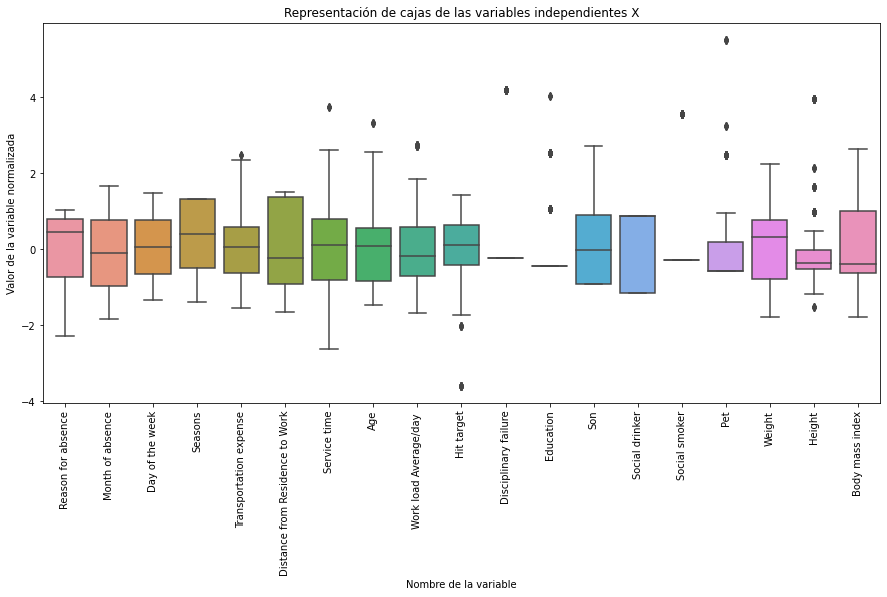

In [13]:
# Representa los boxplot
# Normaliza para tener rangos comparables en las features. No se normaliza la target
X_normalizado = (X-X.mean())/X.std()

plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
_ = plt.xlabel('Nombre de la variable')

Escribe tus conclusiones sobre los boxplots.

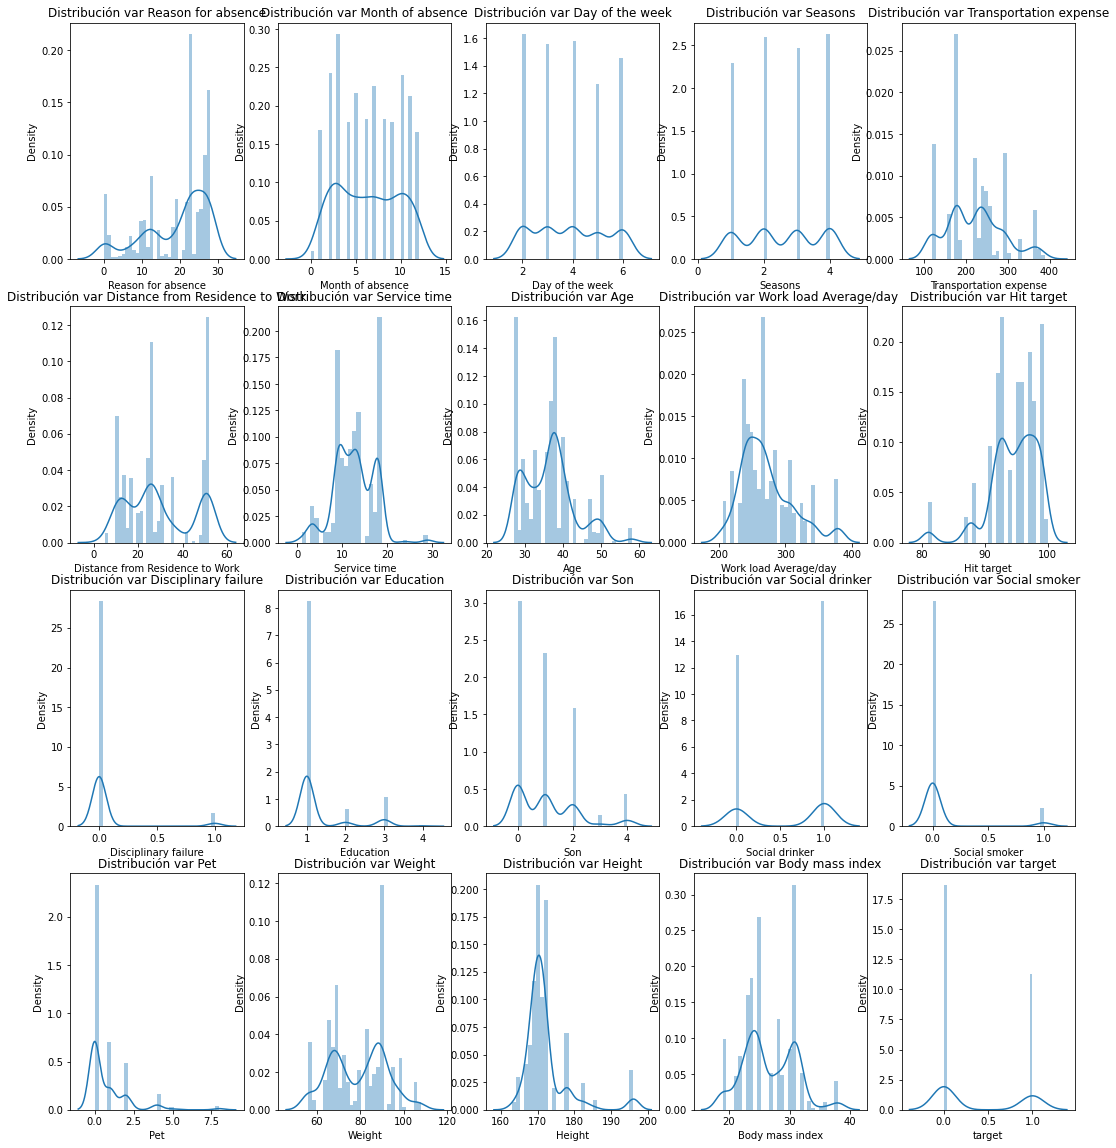

In [14]:
# Representa los histogramas de los datos completos, incluyendo la target
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(XY.columns):
    n+=1
    plt.subplot(4, 5, n)
    sns.distplot(XY[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

Escribe tus conclusiones sobre los histogramas.

## Relación variable vs target: 

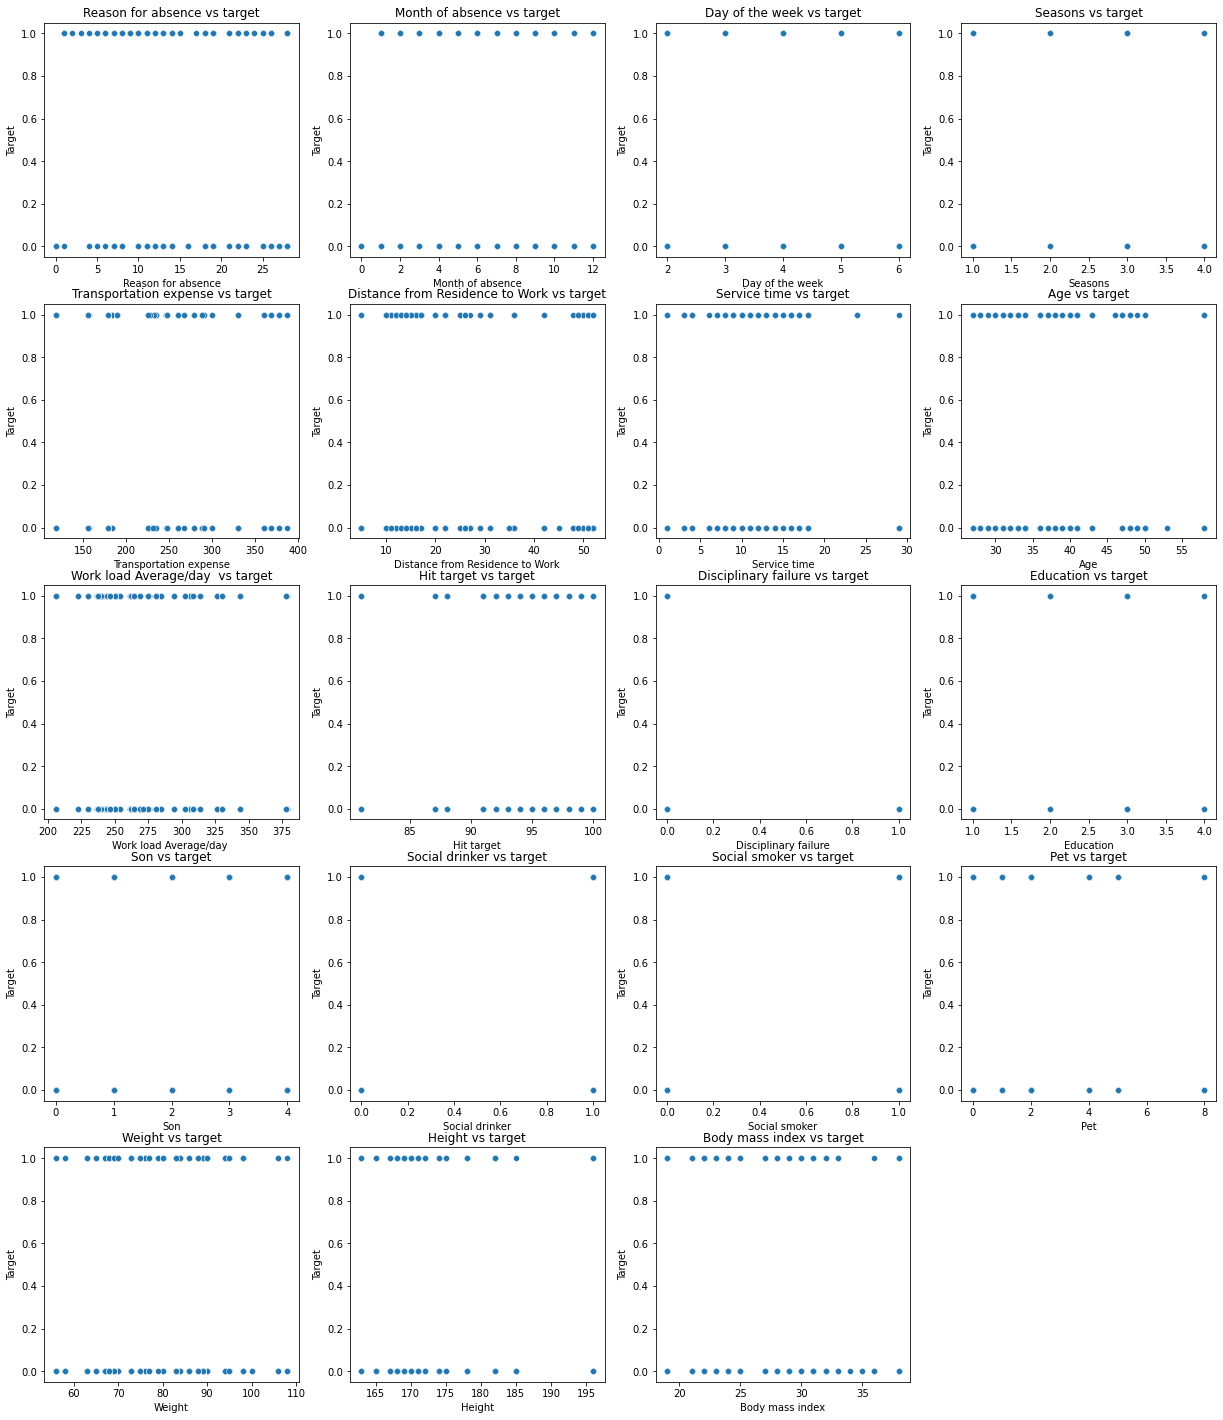

In [15]:
# Representa la relación de las variables independientes y la dependiente
relaciones_vs_target(X, Y)

### Histogramas positivos-negativos

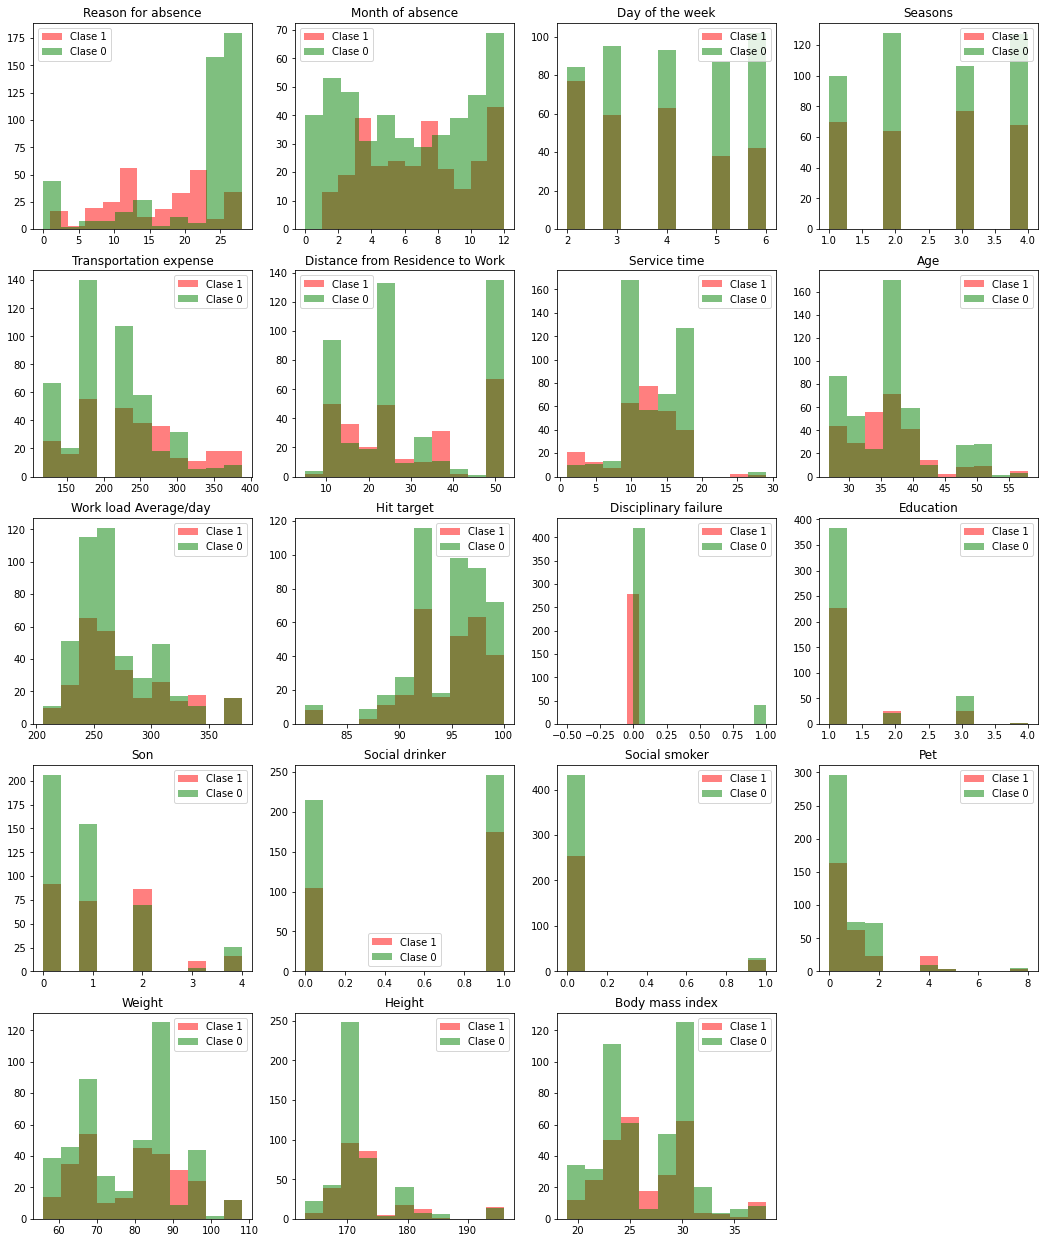

In [16]:
# Representa histogramas separando las features por el valor de la target
hist_pos_neg_feat(X, Y)

Comenta los histogramas, ¿Existen variables que parece que puedan separar mejor las dos clases?.

## Matriz de correlaciones:

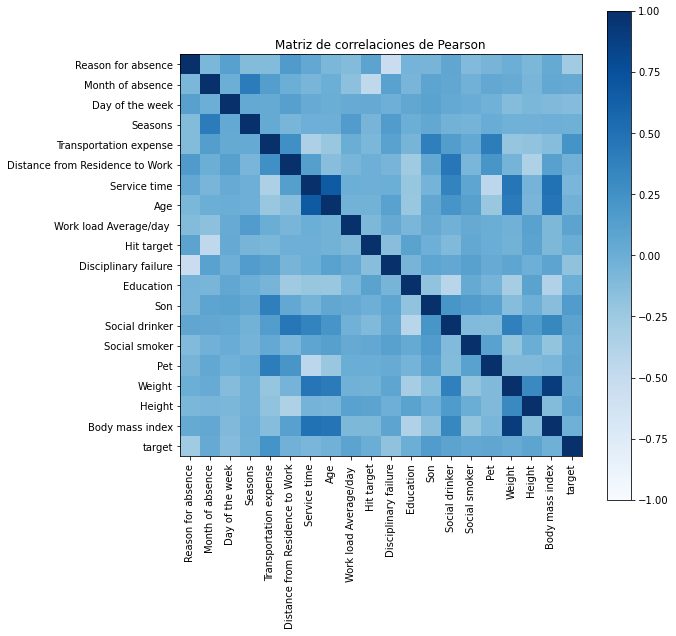

In [17]:
# Representa la matriz de correlaciones
matriz_correlaciones = XY.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Matriz de correlaciones de Pearson')

## Variables con mayor correlación con la target:

In [18]:
# Obtén las variables más y menos correlacionadas con la target
correlaciones_target = matriz_correlaciones.values[ -1, : -1]
indices_inversos =  abs(correlaciones_target[ : ]).argsort()[ : : -1]
diccionario = {}
for nombre, correlacion in zip( X.columns[indices_inversos], list(correlaciones_target[indices_inversos] ) ):
    diccionario[nombre] = correlacion
pd.DataFrame.from_dict(diccionario, orient='index', columns=['Correlación con la target'])

,Correlación con la target
Reason for absence,-0.273394
Transportation expense,0.230672
Disciplinary failure,-0.185966
Son,0.149157
Day of the week,-0.131982
Social drinker,0.088076
Work load Average/day,0.086224
Height,0.079963
Service time,-0.076093
Pet,0.067480


Comenta qué variables pueden ser más o menos predictoras linealmente.

## Estandarización de los datos previa: 

In [19]:
# Estandariza los datos si no vas a usar un modelo basado en árboles
# Si los vas a usar, puedes estandarizar también ya que no perjudica
obj_escalar = StandardScaler()
X_estandarizado = obj_escalar.fit_transform(X)

## División en train y test: 

In [20]:
# Divide los datos en train y test, con un 20 % de tamaño de test
#X_train, X_test, Y_train, Y_test = train_test_split(X_estandarizado, Y, test_size=0.2, random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
# Reviasmos las medidas
print("Shape of x_train :", X_train.shape)
print("Shape of y_train :", Y_train.shape)
print("Shape of x_test :", X_test.shape)
print("Shape of y_test :", Y_test.shape)

Shape of x_train : (592, 19)
Shape of y_train : (592,)
Shape of x_test : (148, 19)
Shape of y_test : (148,)


# Aplicamos un modelo de clasificación

Escoge un modelo de clasificación y aplícalo en los siguientes apartados. Ten en cuenta que hay modelos que necesitan que se cumplan unas hipótesis, como la independencia de variables o la estandarización de los datos. Se valorará como punto positivo utilizar un modelo no lineal.  

## Aplica el modelo por defecto:

In [21]:
# Ajusta el modelo por defecto a los datos de entrenamiento y predice test
modelo = LogisticRegression()
modelo.fit(X_train, Y_train)

LogisticRegression()

In [22]:
# Predice las probabilidades en el conjunto de Test y calcula la métrica ROC AUC
# Se calcula con esta función... sklearn.metrics.roc_auc_score(y_true, y_score[:,1])
y_test_pred_prob = modelo.predict_proba(X_test)
metrics.roc_auc_score(Y_test, y_test_pred_prob[:,1])

0.7163398692810458

## Optimiza los parámetros:

In [23]:
# Optimiza al menos dos parámetros del modelo. La métrica a optimizar queremos que sea la roc_auc
modelo = LogisticRegression()
parametros = {"C": [0., 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,0.09], 
              "class_weight":['balanced', None]}
modelo_gs = GridSearchCV(modelo, param_grid=parametros,
                         cv = 5, scoring='roc_auc')
modelo_gs.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                               0.08, 0.09],
                         'class_weight': ['balanced', None]},
             scoring='roc_auc')

Imprime los mejores parámetros.

In [24]:
print(modelo_gs.best_params_, "\nROC AUC: {}".format(round(modelo_gs.best_score_,2)))

{'C': 0.01, 'class_weight': 'balanced'} 
ROC AUC: 0.73


In [25]:
df_search = pd.DataFrame.from_dict(modelo_gs.cv_results_)

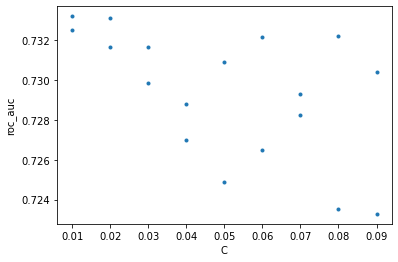

In [26]:
# Representa la métrica en función del valor de uno de los parámetros
plt.xlabel('C')
plt.ylabel('roc_auc')
_ = plt.plot( df_search['param_C'], df_search['mean_test_score'], '.')

In [27]:
# Predice las probabilidades en el conjunto de Test y calcula la métrica ROC AUC
# Se calcula con esta función... sklearn.metrics.roc_auc_score(y_true, y_score[:,1])
y_test_pred_prob = modelo_gs.predict_proba(X_test)
metrics.roc_auc_score(Y_test, y_test_pred_prob[:,1])

0.7182072829131654

Comenta si ha habido algo de mejora o no al optimizar los parámetros y por qué. 

## Representación de las probabilidades

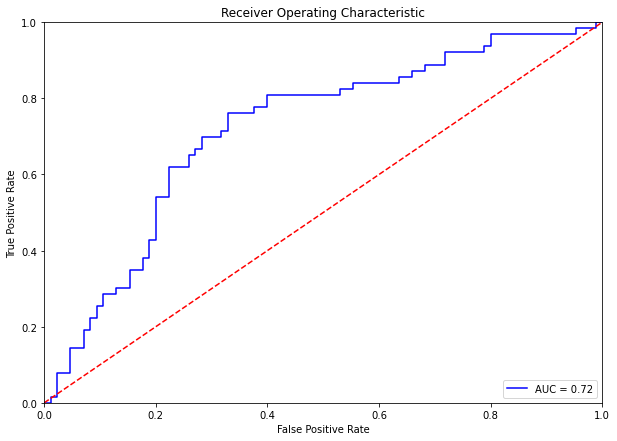

In [28]:
# Representa la curva ROC de las predicciones en Test
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

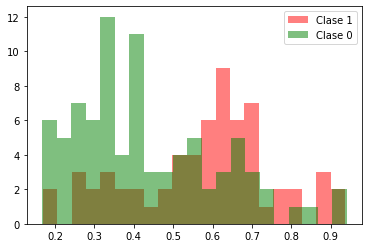

In [29]:
# Representa los histogramas de probabilidad de las predicciones en Test
y_test_pred_prob = modelo_gs.predict_proba(X_test)
y_test_pred_prob_pos = y_test_pred_prob[np.where(Y_test == 1)[0]]
y_test_pred_prob_neg = y_test_pred_prob[np.where(Y_test == 0)[0]]

represento_doble_hist(y_test_pred_prob_pos[:, 1], y_test_pred_prob_neg[:, 1], n_bins = 21, density = 0)

Imagina que la empresa lo que necesita sí o sí es detectar el máximo número de personas que faltan al trabajo, para ello le importa poco los falsos positivos... es decir, le interesa la sensitividad ¿Qué umbral de los siguientes debemos usar para optimizar la sensitividad?

$$umbrales = 0.1,0.2,0.3,0.5,0.6,0.8$$

In [30]:
# Calcula las sensitividades en función a los umbrales anteriores
sensitividades = {}
for umbral in [0.1, 0.2, 0.3, 0.5, 0.6, 0.8]:
    y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)
    sensitividades[umbral] = metrics.recall_score(Y_test, y_umbralizadas)
sensitividades

{0.1: 1.0,
 0.2: 0.9682539682539683,
 0.3: 0.9206349206349206,
 0.5: 0.7301587301587301,
 0.6: 0.5238095238095238,
 0.8: 0.09523809523809523}

Imagina que la empresa lo que necesita sí o sí es detectar con seguridad a las personas que faltan al trabajo, ... es decir, le interesa la precisión ¿Qué umbral de los siguientes debemos usar para optimizar la precisión?

$$umbrales = 0.1,0.2,0.3,0.5,0.6,0.8$$

In [31]:
precisiones = {}
for umbral in [0.1, 0.2, 0.3, 0.5, 0.6, 0.8,0.9]:
    y_umbralizadas = 1*(y_test_pred_prob[:, 1] > umbral)
    precisiones[umbral] = metrics.precision_score(Y_test, y_umbralizadas)
precisiones

{0.1: 0.42567567567567566,
 0.2: 0.4357142857142857,
 0.3: 0.48333333333333334,
 0.5: 0.6216216216216216,
 0.6: 0.66,
 0.8: 0.6,
 0.9: 0.5}

In [32]:
# Calcula las métricas accuracy, sensitividad, predición y la matriz de confusión con el umbral 
# por defecto 0.5
y_umbralizadas = 1*(y_test_pred_prob[:, 1] > 0.5)
print(u"Matriz de confusión\n", metrics.confusion_matrix(Y_test, y_umbralizadas))
print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y_test, y_umbralizadas),2)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y_test, y_umbralizadas),2)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y_test, y_umbralizadas),2)))  

Matriz de confusión
 [[57 28]
 [17 46]]

Accuracy	0.7
Sensitividad	0.73
Precisión	0.62
